### Forcasting a Time Series

forecasting number of passengers that will ride on bus the next day:

In [1]:
import pandas as pd
from pathlib import Path

path = Path('./data/CTA_Ridership_Daily_Boarding_Totals_20250210.csv')
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)
df = df.drop_duplicates()

In [2]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


^ W for weekday, A for Saturday, U for Sunday or Holidays

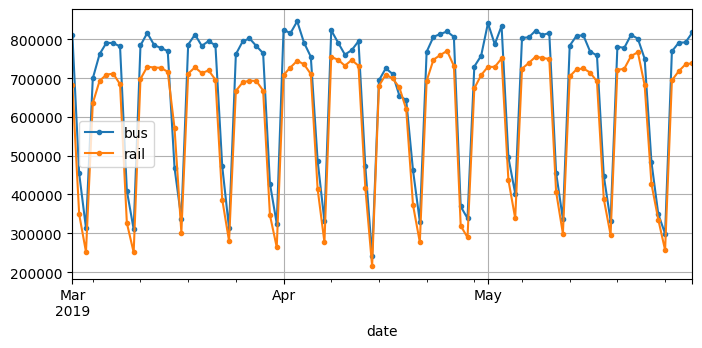

In [11]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

multiple values per time step, this is called a multivariate time series.

naive forecasting: copying the latest known value (e.g. forecasting that tomorrow will be the same as today, using last weeks data to predict next weeks)

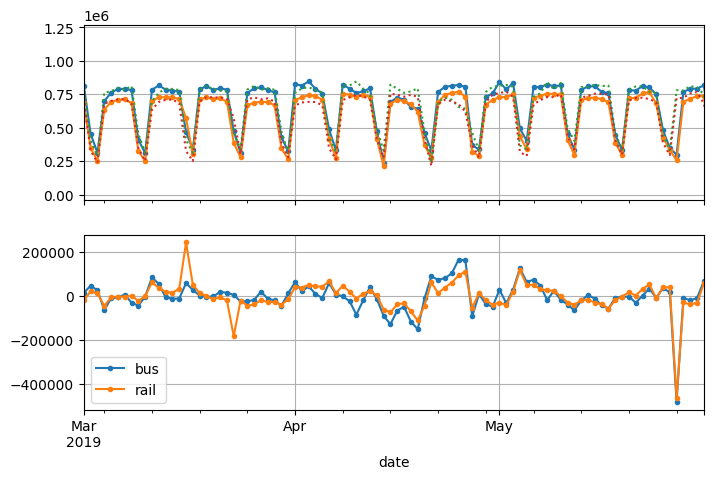

In [13]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".") # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":") # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".") # 7-day difference time series
plt.show()

In [14]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

In [16]:
diff_7.abs().mean().round(2)

bus     43915.61
rail    42143.27
dtype: float64

Mean abosulte percentage error (MAPE):

In [18]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

MAE, MAPE, and MSE are common metrics. MSE may be preferable if your project suffers quadratically more from large errors than from small ones.

12-month rolling average

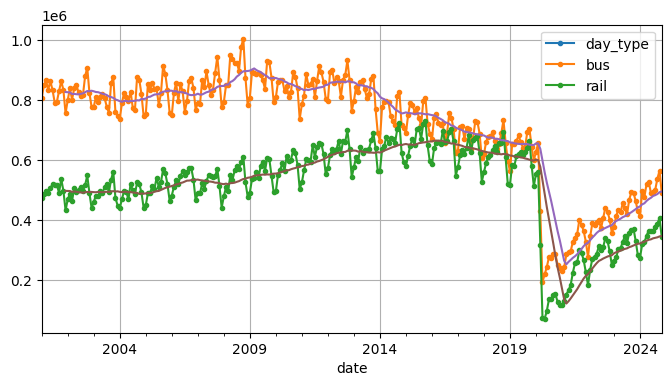

In [22]:
df = df.apply(pd.to_numeric, errors="coerce") # Convert all columns to numeric, setting non-numeric to NaN

period = slice("2001", "2024")
df_monthly = df.resample("ME").mean() # mean of each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8,4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

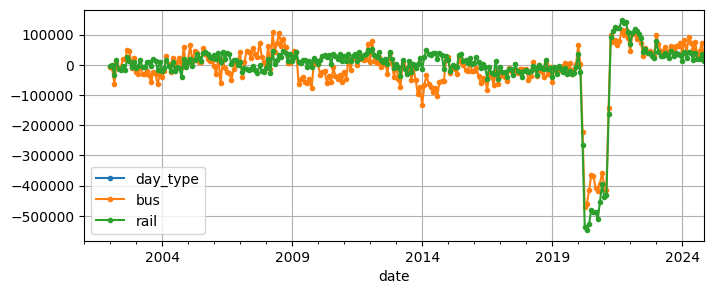

In [23]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8,3))
plt.show()

differencing is a common technique used to remove trend and seasonality from a time series it's easier to study a stationary time series whose statistical properties remain constant over time, without any seasonality or trends. 

## Understanding Stationarity in Time Series

When a model **assumes that the time series is stationary**, it means the model expects the statistical properties of the data—such as **mean, variance, and autocorrelation**—to remain **constant over time**.

### Why Does This Matter?
Many forecasting models, like ARIMA and classical regression models, rely on this assumption because they work best when patterns in the data don’t change over time.

### How Do You Check for Stationarity?
A time series is stationary if:
- ✅ The **mean** (average value) stays roughly the same over time.
- ✅ The **variance** (spread of values) remains constant.
- ✅ The **autocorrelation** (relationship between values at different time points) does not change.

### What If the Data Is Not Stationary?
If a time series has **trends** (increasing or decreasing over time) or **seasonality** (repeating patterns), it is **non-stationary**. You may need to:
- **Take differences** (e.g., a 7-day difference) to remove trends.
- **Apply transformations** (e.g., log or square root) to stabilize variance.
- **Use seasonal adjustments** if there are repeating patterns.

Would you like an example of how to check and transform a non-stationary time series? 🚀

forecast tomorrow the 1st of June 2019 using ARIMA

In [26]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 26.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [29]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D") # daily
# order=(1, 0, 0): p=1, d=0, q=0 seasonal_order=(0, 1, 1, 7): P=0, D=1, Q=1, s=7
model = ARIMA(rail_series, order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()
y_pred

2019-06-01    427758.626307
Freq: D, dtype: float64

^ The forecast is 427,759 passengers, when in fact there were 379,044

maybe just unlucky that day? Lets check MAE for everyday in March, April, May

In [38]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start=start_date, end=end_date)

# Ensure rail_series has DateTimeIndex
df.index = pd.to_datetime(df.index)
rail_series = df.loc[origin:end_date, "rail"].asfreq("D")

y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series.loc[origin:today],
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()
    y_pred = model.forecast().iloc[0]
    y_preds.append(y_pred)

# Ensure index alignment
y_preds = pd.Series(y_preds, index=time_period)

# Use `.loc` instead of direct indexing
mae = (y_preds - rail_series.loc[time_period[:-1]]).abs().mean()

mae

np.float64(31960.99751252199)

to pick good hyperparameters for the SARIMA model brute-force approach: run a grid search. For each model you want to evaluate (i.e. each hyperparameter combination), changing only the hyperparameter values. Good p, q, P, and Q values are usually fairly small (typically 0 to 2, sometimes up to 5 or 6), and d and D are typically 0 or 1, sometimes 2. As for s, it’s just the main seasonal pattern's period: in our case it’s 7 since there’s a strong weekly seasonality. The model with the lowest MAE wins.

In [39]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:], # targets are 3 steps into future
    sequence_length=3,
    batch_size=2
)

In [40]:
list(my_dataset)

2025-02-10 23:11:24.809546: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

window datasets

In [44]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True):
   for element in window_dataset:
       print(f"{element}", end=" ")
   print()

0 1 2 3 
1 2 3 4 
2 3 4 5 


In [45]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


helper function

In [46]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [56]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

We are predicting the next sequence
#### First:
`to_windows(tf.data.Dataset.range(6), 4)`\
[0, 1, 2, 3]\
[1, 2, 3, 4]\
[2, 3, 4, 5]

#### Second:
`dataset.map(lambda window: (window[:-1], window[-1]))`\
([0, 1, 2], 3)\
([1, 2, 3], 4)\
([2, 3, 4], 5)

#### Third:
`list(dataset.batch(2))`\
[\
    ( [[0, 1, 2], [1, 2, 3]],  [3, 4] ),\
    ( [[2, 3, 4]], [5] )\
]

Scaled down by a factor of one million

In [58]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

When dealing with time series, you generally want to split across time.

gradient descent expects the instances in the training set to be independent and identically distributed (IID)

In [59]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

### Forcasting Linear Model:

Huber Loss and early stopping, works better than minimizing MAE

In [71]:
tf.random.set_seed(42)
tf.config.run_functions_eagerly(True)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True
)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1526 - mae: 0.4645 - val_loss: 0.0102 - val_mae: 0.1094
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106 - mae: 0.1108 - val_loss: 0.0081 - val_mae: 0.0952
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - mae: 0.0948 - val_loss: 0.0071 - val_mae: 0.0884
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - mae: 0.0896 - val_loss: 0.0067 - val_mae: 0.0844
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - mae: 0.0846 - val_loss: 0.0065 - val_mae: 0.0844
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mae: 0.0787 - val_loss: 0.0057 - val_mae: 0.0771
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - mae: 0.0768 - val_loss: 0.0054 - val_mae: 0.0748
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - mae: 0.0782 - val_loss: 0.0051 - val_mae: 0.0714
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.006

### Forcasting RNN

All recurrent layers in Keras expect 3D inputs of shape `[batch size, time steps, dimensionality]`, where dimensionality is 1 for univariate time series and more for multivariate time series. 

In [74]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=[None, 1]), # None here is "any size" time steps, univariate=1 (univariate sequences of any length)
    tf.keras.layers.SimpleRNN(1)
])

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="mse", optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 1.1703 - mae: 0.8827 - val_loss: 0.1568 - val_mae: 0.3550
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.1382 - mae: 0.3244 - val_loss: 0.0936 - val_mae: 0.2522
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0645 - mae: 0.1870 - val_loss: 0.0314 - val_mae: 0.1462
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0321 - mae: 0.1617 - val_loss: 0.0306 - val_mae: 0.1358
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0312 - mae: 0.1542 - val_loss: 0.0293 - val_mae: 0.1331
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0306 - mae: 0.1537 - val_loss: 0.0281 - val_mae: 0.1308
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0280 - mae: 0.1463 - val_loss: 0.0268 - val_mae: 0.1302
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0281 - mae: 0.1476 - val_loss: 0.0261 - val_mae: 0.1262
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - lo

^ this of course has limited memory 1 neuron

In [75]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="mse", optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.1168 - mae: 0.2680 - val_loss: 0.0224 - val_mae: 0.1096
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0134 - mae: 0.0897 - val_loss: 0.0053 - val_mae: 0.0519
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0083 - mae: 0.0612 - val_loss: 0.0052 - val_mae: 0.0508
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0074 - mae: 0.0552 - val_loss: 0.0043 - val_mae: 0.0397
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0074 - mae: 0.0528 - val_loss: 0.0050 - val_mae: 0.0426
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0059 - mae: 0.0468 - val_loss: 0.0045 - val_mae: 0.0371
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0063 - mae: 0.0479 - val_loss: 0.0040 - val_mae: 0.0319
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0062 - mae: 0.0456 - val_loss: 0.0050 - val_mae: 0.0398
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - lo

^ We've only normalized the time series, without removing trend and seasonality, and yet the model still performs well.

In [67]:
deep_model = tf.keras.Sequential([
    tf.keras.Input(shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

The shallow model performs better on our data than the deep one

### Multivariate Time Series

In [127]:
# somewhere along the line I had dropped day_type so redefining the df here:
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)
df = df.drop_duplicates()


df_mulvar = df[["bus", "rail"]] / 1e6
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # tomorrow
df_mulvar = pd.get_dummies(df_mulvar) # one-hot encode day type (three possible day types, W, A, and U))

^ 5 columns: `[bus, rail, one-hot-encode-day-type]` 

Had to convert the one hot encoding from True/False to 1.0/0.0 otherwise `tf.keras.utils.timeseries_dataset_from_array` would complain

In [137]:
import numpy as np

mulvar_train = df_mulvar["2016-01":"2018-12"].astype(np.float32)
mulvar_valid = df_mulvar["2019-01":"2019-05"].astype(np.float32)
mulvar_test = df_mulvar["2019-06":].astype(np.float32)

In [134]:
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

/Users/mathias/.pyenv/versions/3.12.0/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [135]:
mulvar_model = tf.keras.Sequential([
    tf.keras.Input(shape=[None, 5]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
mulvar_model.compile(loss="mse", optimizer=opt, metrics=["mae"])
history = mulvar_model.fit(train_mulvar_ds, validation_data=valid_mulvar_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.1693 - mae: 0.3082 - val_loss: 0.0072 - val_mae: 0.0736
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0086 - mae: 0.0729 - val_loss: 0.0064 - val_mae: 0.0721
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0047 - mae: 0.0503 - val_loss: 0.0020 - val_mae: 0.0351
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0028 - mae: 0.0375 - val_loss: 0.0014 - val_mae: 0.0270
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0026 - mae: 0.0366 - val_loss: 0.0013 - val_mae: 0.0247
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0028 - mae: 0.0390 - val_loss: 0.0013 - val_mae: 0.0256
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0024 - mae: 0.0360 - val_loss: 0.0014 - val_mae: 0.0264
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0024 - mae: 0.0351 - val_loss: 0.0013 - val_mae: 0.0244
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - lo

^ much better results!

Instead of one day ahead lets forecast 2 weeks ahead:

In [140]:
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


train an RNN to predict the next 14 values in one shot

In [141]:
def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [143]:
ahead_model = tf.keras.Sequential([
    tf.keras.Input(shape=[None, 5]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(14)
])

In [144]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
Y_pred = ahead_model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


### Forcasting using a Sequence-to-Sequence Model

we should train the next 14 values at each step, instead of just the last step

instead of a sequence-to-vector RNN we need to turn it into a sequence-to-sequence RNN

at time step 0 the model will output a vector containing the forecasts for time steps 1 to 14, then at time step 1 the model will forecast time steps 2 to 15, and so on. 

In [148]:
# 4 consecutive windows, each of length 3
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

In [149]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

In [150]:
def to_seq2seq_dataset(
    series,
    seq_length=56,
    ahead=14,
    target_col=1,
    batch_size=32,
    shuffle=False,
    seed=None
):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [151]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

/Users/mathias/.pyenv/versions/3.12.0/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/mathias/.pyenv/versions/3.12.0/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [152]:
seq2seq_model = tf.keras.Sequential([
    tf.keras.Input(shape=[None, 5]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

In [153]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


### RNNs aren't good on long sequences

A way to fight unstable gradients is to have a memory cell (ouputs from previous time step) and apply layer normalization

In [155]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, state):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [156]:
custom_ln_model = tf.keras.Sequential([
    tf.keras.Input(shape=[None, 5]),
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True),
    tf.keras.layers.Dense(14)
])

/Users/mathias/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


most recurrent layers and cells provided by Keras have 
- **dropout:** dropout rate to apply to the inputs
- **recurrent_dropout:** dropout rate for the hidden states, between time steps

### LSTM (long sort-term memory)

after a while the information that flows through RNN eventually it will have no trace of the first inputs

In [157]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=[None, 5]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

LSTM and GRU cells are one of the main reasons behind the success of RNNs, GRU performs just as well as LSTM but their architecture is much simplier

### 1D convolutional layers

used to process long sequences like audio files, we can use the same example as earlier:

In [159]:
conv_rnn_model = tf.keras.Sequential([
    tf.keras.Input(shape=[None, 5]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2, activation="relu"),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112, shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

/Users/mathias/.pyenv/versions/3.12.0/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/mathias/.pyenv/versions/3.12.0/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


### A Wavenet model:

In [161]:
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.Input(shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate
    ))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

"causal" padding, which is like "same" padding except that the zeros are appended only at the start of the input sequence, instead of on both sides.